# Traffic Flow Regression
This notebook uses supervised learning to create a machine learning model that can predict the traffic flow at a junction given a set of inputs

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, validation_curve
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
from mlxtend.evaluate import bias_variance_decomp
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR


# Imports

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns



# Read in Data


In [67]:
df = pd.read_csv('../../transformed_datasets/base_dataset.csv', parse_dates=True, index_col=None)

## Choose Site
We will just focus on Site N03121A because it is isolated making it less likely for multicollinearity to occur (where features depend on each other)

In [68]:
df = df[df['site']=='N03121A']
df

,scn,region,locn,X,Y,site,day,date,start_time,end_time,...,rhum,msl,month,previous_flow_N01111A,previous_flow_N01131A,previous_flow_N01151A,previous_flow_N02111A,previous_flow_N02131A,previous_flow_N03121A,overall_previous_flow
86864,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,SA,2022-01-01,00:00:00,00:15:00,...,80,1007.3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86865,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,SA,2022-01-01,00:15:00,00:30:00,...,80,1007.3,1,54.0,27.0,22.0,67.0,42.0,30.0,242.0
86866,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,SA,2022-01-01,00:30:00,00:45:00,...,80,1007.3,1,62.0,59.0,29.0,72.0,33.0,56.0,311.0
86867,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,SA,2022-01-01,00:45:00,01:00:00,...,70,1005.8,1,95.0,66.0,33.0,84.0,66.0,64.0,408.0
86868,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,SA,2022-01-01,01:00:00,01:15:00,...,70,1005.8,1,75.0,64.0,47.0,92.0,67.0,52.0,397.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104232,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,SU,2022-12-06,22:45:00,23:00:00,...,88,1028.3,12,151.0,0.0,57.0,152.0,113.0,130.0,603.0
104233,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,SU,2022-12-06,23:00:00,23:15:00,...,88,1028.3,12,85.0,0.0,50.0,131.0,86.0,97.0,449.0
104234,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,SU,2022-12-06,23:15:00,23:30:00,...,88,1028.3,12,65.0,0.0,36.0,112.0,73.0,54.0,340.0
104235,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,SU,2022-12-06,23:30:00,23:45:00,...,87,1028.3,12,60.0,0.0,43.0,99.0,53.0,78.0,333.0


## Feature Selection

In [69]:
cat_features = ['day',
                'time_(half_hour)',
                'month']
num_features = ['previous_flow_N01111A',
                'previous_flow_N01151A',
                'previous_flow_N02111A',
                'previous_flow_N02131A',
                'previous_flow_N03121A',
                'overall_previous_flow',
                'rain', 
                'temp', 
                'wetb', 
                'dewpt',
                'vappr',
                'rhum',
                'msl']
metadata = ['datetime']


In [70]:
#  Convert 'start_time' and 'date' to datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['date'] = pd.to_datetime(df['date'])

# Round the start_time to the nearest half-hour
df['start_time'] = df['start_time'].dt.round('30min')

# Extract half-hour intervals (0 for the hour, 30 for half past)
df['time_(half_hour)'] = df['start_time'].dt.strftime('%H:%M')

# Group by the new half-hour intervals along with other specified columns
df = df.groupby(cat_features+num_features).agg({'flow': 'sum'}).reset_index()

# Display the first few rows
df

/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12340/3154464188.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_time'] = pd.to_datetime(df['start_time'])


,day,time_(half_hour),month,previous_flow_N01111A,previous_flow_N01151A,previous_flow_N02111A,previous_flow_N02131A,previous_flow_N03121A,overall_previous_flow,rain,temp,wetb,dewpt,vappr,rhum,msl,flow
0,FR,00:00,1,17.0,14.0,79.0,57.0,65.0,265.0,0.0,2.9,2.6,2.0,7.1,93,1035.3,31
1,FR,00:00,1,18.0,19.0,52.0,30.0,54.0,211.0,0.0,4.9,3.9,2.5,7.3,84,1042.1,36
2,FR,00:00,1,23.0,17.0,26.0,17.0,40.0,123.0,0.0,3.6,2.2,-0.3,6.0,75,1003.5,49
3,FR,00:00,1,24.0,23.0,79.0,39.0,64.0,272.0,0.0,4.1,3.5,2.6,7.4,90,1039.5,49
4,FR,00:00,1,32.0,24.0,56.0,31.0,49.0,238.0,0.0,4.1,3.5,2.6,7.4,90,1039.5,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17368,WE,23:30,8,39.0,36.0,117.0,84.0,82.0,358.0,0.0,11.9,11.0,10.1,12.4,89,1029.2,85
17369,WE,23:30,9,37.0,26.0,52.0,49.0,82.0,246.0,0.0,16.1,12.8,9.8,12.1,65,1005.4,45
17370,WE,23:30,9,48.0,32.0,58.0,46.0,72.0,256.0,0.2,13.7,13.3,12.9,14.9,95,1005.2,43
17371,WE,23:30,11,68.0,36.0,108.0,73.0,81.0,366.0,0.0,10.8,9.2,7.4,10.3,79,1001.6,67


### Numerical Features - Correlation Matrix

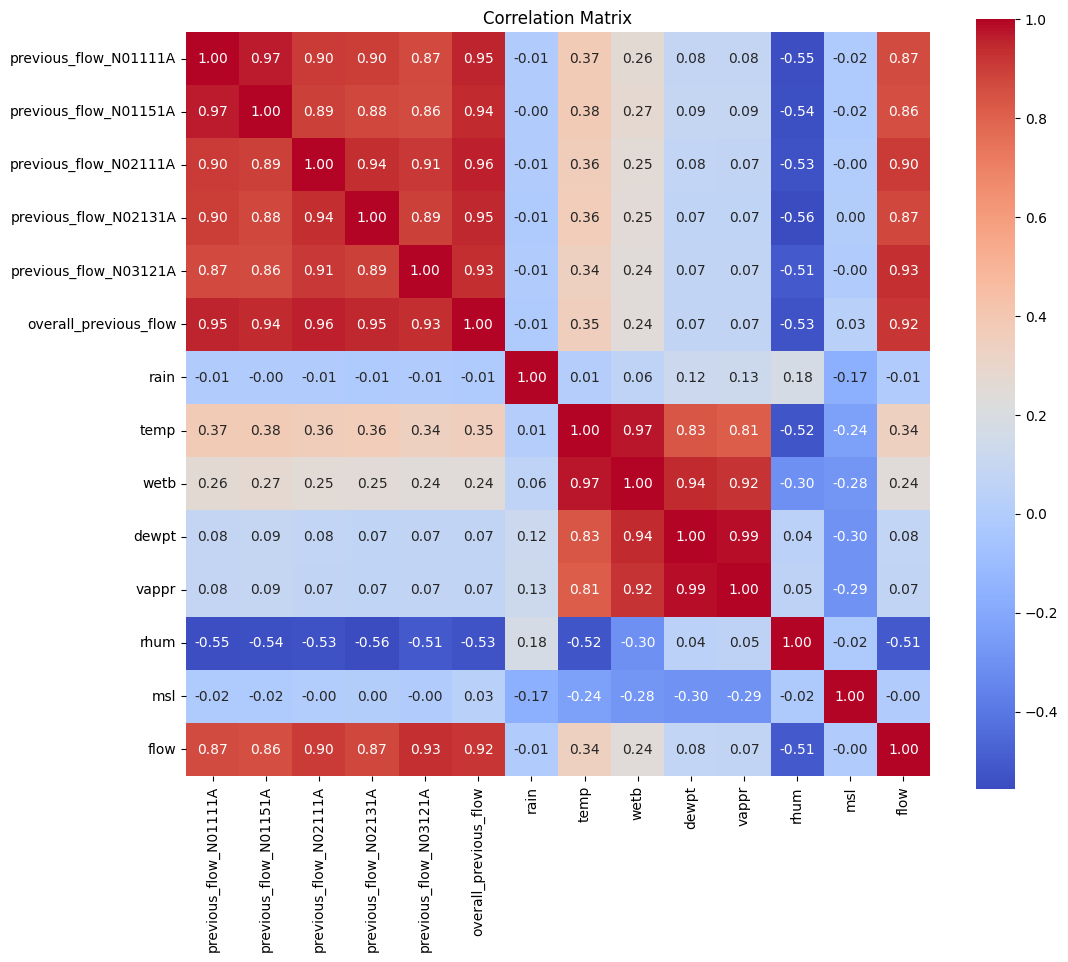

In [71]:
corr_features = num_features+ ['flow']
correlation_matrix = df[corr_features].corr()

# Set the size of the plot
plt.figure(figsize=(12, 10))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Show the plot
plt.title('Correlation Matrix')
plt.show()



Observations
- The previous flows at other sites are highly correlated to each other
- Temperature is highly correlated with wet bulb and dew point temperature.
- we see that the current flow (our target variable)

### Train test split

In [72]:
X = df[num_features+cat_features]
y = df['flow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Model Selection
- From v2 notebook we saw Linear Regression, KNN and the multi-layer perceptron gave the best performance for predicting the traffic flow
- We will now focus on landing on the best final model to use via hyperparameter tuning

## 1. An interpretable model
- Interpretability of a machine learning model can often be hugely important and valuable for key stakeholders
- Deep learning and neural networks create models that can provide excellent performance, however the complexity of these models make them difficult to interpret, meaning we cannot understand why the network is predicting the way it is based on the input features
**Why is interpretability important?**
- One of the use cases of our traffic flow model could be to help make decisions on traffic management systems
- Having accurate predictions of traffic flow is definetly useful, but what is also useful is understanding why traffic is predicted to be higher at a certain time 
- This could perhaps help the council identify some root causes of high traffic flow and thus fix any problems at the root of the issue rather than responding to traffic flow in real time with our complex but accurate neural network model
- Don't get me wrong, having an accurate prediction model is still hugely useful, especially in a scenario like this where you are realistically always going to have periods of high traffic flow. However with the massive advances in machine learning it can become easy to dismiss simpler models if they are not providing sufficient predictive power. However issues like this highlight they are still hugely useful and actually display real benefits over powerful neural networks at times

### 1.1 Linear Regression
- we use one hot encoding and numerical feature scaling for data preprocessing

In [73]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  # Set the depth
])

Lets now evaluate the performance of linear regression using 5-fold cross validation on the train and test cets

In [74]:
def cross_validate_train_and_test(pipeline, cv, X, y):

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    train_maes = []
    test_maes = []

    train_r2s = []
    test_r2s = []

    for train_index, val_index in kf.split(X):
        X_cv_train, X_cv_val = X.iloc[train_index], X.iloc[val_index]  # Use iloc for DataFrame
        y_cv_train, y_cv_val = y.iloc[train_index], y.iloc[val_index]  # Consistent naming

        # Fit the model
        pipeline.fit(X_cv_train, y_cv_train)

        # Calculate train and test errors
        predictions_train = pipeline.predict(X_cv_train)
        predictions_val = pipeline.predict(X_cv_val)
        
        mae_train = mean_absolute_error(y_cv_train, predictions_train)
        mae_val = mean_absolute_error(y_cv_val, predictions_val)

        r2_train = r2_score(y_cv_train, predictions_train)
        r2_test = r2_score(y_cv_val, predictions_val)


        train_maes.append(mae_train)
        test_maes.append(mae_val)

        train_r2s.append(r2_train)
        test_r2s.append(r2_test)

    mean_mae_test = np.mean(test_maes)
    mean_mae_train = np.mean(train_maes)
    mean_r2_test = np.mean(test_r2s)
    mean_r2_train = np.mean(train_r2s)

    print('Mean MAE Test:', mean_mae_test)
    print('Mean MAE Train:', mean_mae_train)
    print('Mean R2 Test:', mean_r2_test)
    print('Mean R2 Train:', mean_r2_train)

    return mean_mae_test, mean_mae_train, mean_r2_test, mean_r2_train

In [75]:
cross_validate_train_and_test(pipeline_lr, 5, X, y)

Mean MAE Test: 38.35543574528768
Mean MAE Train: 38.14237851358716
Mean R2 Test: 0.8991351548998322
Mean R2 Train: 0.900293488038453


(np.float64(38.35543574528768),
 np.float64(38.14237851358716),
 np.float64(0.8991351548998322),
 np.float64(0.900293488038453))

#### Observations
- The key thing to notice here is the very close values between the train and test errors. This indicates the model is **underfitting** and error in the model is dominated by the **bias**
    - lets verify this via a bias-variance decomposition of the squared error

#### Bias-Variance Decompisition

In [98]:
def bias_variance_pipeline(pipeline, X, y):

        pipeline.fit(X_train, y_train)
        # Separate the preprocessing step from the pipeline
        preprocessor = pipeline.named_steps['preprocessor']

        # Transform the training and test data using the preprocessing step
        X_train_processed = preprocessor.transform(X_train)
        X_test_processed = preprocessor.transform(X_test)

        # Now pass the processed NumPy arrays to bias_variance_decomp
        avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
                pipeline.named_steps['regressor'],  # Use only the regressor step here
                X_train_processed, y_train.ravel(),  # Processed data (NumPy arrays)
                X_test_processed, y_test.ravel(),    # Processed data (NumPy arrays)
                loss='mse',
                random_seed=123)

        print(f"Average Expected Loss: {avg_expected_loss}")
        print(f"Average Bias: {avg_bias}")
        print(f"Average Variance: {avg_var}")


In [99]:
bias_variance_pipeline(pipeline_lr, X_train, y_train)

/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12340/1476791940.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_processed, y_train.ravel(),  # Processed data (NumPy arrays)
/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12340/1476791940.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_test_processed, y_test.ravel(),    # Processed data (NumPy arrays)


Average Expected Loss: 3307.6018617836885
Average Bias: 3287.837837465132
Average Variance: 19.764024318556817


#### Observations
- as predicted, the majority of the expected loss is coming from the bias term as opposed to the variance 
- we could therefore look at more complex model
    - One we we could increase the complexity of the model is via polynomial features so let's try this

##### 2.2.1.1 Polynomial Regression

In [106]:
def create_poly_pipeline(degree):
    preprocessor = ColumnTransformer(
            transformers=[
                ('num', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                    ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree=degree))  # Standardize numerical features
                ]), num_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
            ]
            )

    # Create the pipeline
    pipeline_lr_poly = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())  # Set the depth
    ])
    return pipeline_lr_poly

Let's experiment with a few values of "degree" that controls the exponent of the polynomial

In [107]:
mae_test = []
mae_train = []
degrees = [1, 2, 3, 4]#, 5]
for degree in degrees:
    print('Degree Polynomial: ', degree)
    mean_mae_test, mean_mae_train, _, _ = cross_validate_train_and_test(create_poly_pipeline(degree), 5, X, y)
    mae_test.append(mean_mae_test)
    mae_train.append(mean_mae_train)
    print('')


Degree Polynomial:  1
Mean MAE Test: 38.3554359969625
Mean MAE Train: 38.14237847076767
Mean R2 Test: 0.8991351546859712
Mean R2 Train: 0.9002934880384841

Degree Polynomial:  2
Mean MAE Test: 38.001085695632725
Mean MAE Train: 37.41802561271908
Mean R2 Test: 0.9029014434690797
Mean R2 Train: 0.9062798067836673

Degree Polynomial:  3
Mean MAE Test: 38.54449205940208
Mean MAE Train: 35.994219740206844
Mean R2 Test: 0.8969420821884739
Mean R2 Train: 0.914036392899092

Degree Polynomial:  4
Mean MAE Test: 50.33159282058112
Mean MAE Train: 31.42253806607578
Mean R2 Test: 0.6465130667985333
Mean R2 Train: 0.9363197630205631



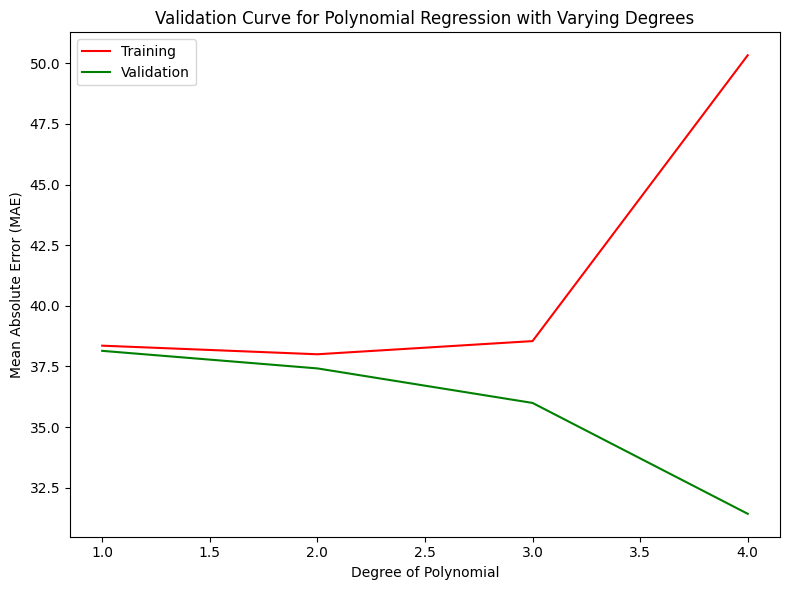

In [108]:
plt.figure(figsize=(8, 6))
plt.plot(degrees, mae_test, label="Training", color="r")
plt.plot(degrees, mae_train, label="Validation", color="g")
plt.title("Validation Curve for Polynomial Regression with Varying Degrees")
plt.xlabel("Degree of Polynomial")
plt.ylabel("Mean Absolute Error (MAE)")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### Observations
- We see that the training and test MAE actually start to diverge as we increase the degree of the polynomial. This shows we are fitting the training data better, but at the cost of decreased generalisation performance i.e. we are overfitting
- Simple linear regression is therefore the most optimal model to pick as it is the most interpretable and produces a good score on the test set

### 2.2.1 Support Vector Machine

In [109]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel="rbf")) 
])

In [110]:
cross_validate_train_and_test(pipeline_svm, 5, X, y)

Mean MAE Test: 45.7036949926512
Mean MAE Train: 45.382534722541884
Mean R2 Test: 0.8523612496097138
Mean R2 Train: 0.8534408066036206


(np.float64(45.7036949926512),
 np.float64(45.382534722541884),
 np.float64(0.8523612496097138),
 np.float64(0.8534408066036206))

## 2.3 Tree Models

### 2.3.1 Decision Tree
(No preprocessing steps needed for decision tree)

In [111]:
preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())  # Set the depth
])

In [94]:
cross_validate_train_and_test(pipeline_dt, 5, X, y)

Mean MAE Test: 44.40058133642664
Mean MAE Train: 33.35980314437751
Mean R2 Test: 0.8518561013072491
Mean R2 Train: 0.9102893450078102


(np.float64(44.40058133642664),
 np.float64(33.35980314437751),
 np.float64(0.8518561013072491),
 np.float64(0.9102893450078102))

#### Observations
- The decision tree has decent performance but not better than linear regression
- We can see if the error is coming from the bias or variance term

In [95]:
bias_variance_pipeline(pipeline_dt, X, y)

/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12340/1476791940.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_processed, y_train.ravel(),  # Processed data (NumPy arrays)
/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12340/1476791940.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_test_processed, y_test.ravel(),    # Processed data (NumPy arrays)


Average Expected Loss: 5427.756386947755
Average Bias: 4566.670844531941
Average Variance: 861.085542415814


We see again the bias is much higher than the variance.
- Let's try more complex tree models

### 2.3.2 Random Forest & GBT

In [113]:
preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500))  
])

pipeline_gbt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=500))
])

In [114]:
print('Random Forest \n')
cross_validate_train_and_test(pipeline_rf, 5, X, y)
print('Gradient Boosted Tree')
cross_validate_train_and_test(pipeline_gbt, 5, X, y)


Random Forest 

Mean MAE Test: 43.123149306313486
Mean MAE Train: 34.09173909464775
Mean R2 Test: 0.8603493717754327
Mean R2 Train: 0.909326531552671
Gradient Boosted Tree
Mean MAE Test: 45.27434884910299
Mean MAE Train: 43.95894599348047
Mean R2 Test: 0.8591504965847129
Mean R2 Train: 0.868349242212461


(np.float64(45.27434884910299),
 np.float64(43.95894599348047),
 np.float64(0.8591504965847129),
 np.float64(0.868349242212461))

- Results are still poor so lets not go with a tree model

## 2.4 Other Models

### 2.4.1 KNN

In [96]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=4, n_jobs=-1)) 
])

In [97]:
cross_validate_train_and_test(pipeline_knn, 5, X, y)


Mean MAE Test: 40.58127355386848
Mean MAE Train: 28.692544198754376
Mean R2 Test: 0.8820735409461431
Mean R2 Train: 0.9412355601851665


(np.float64(40.58127355386848),
 np.float64(28.692544198754376),
 np.float64(0.8820735409461431),
 np.float64(0.9412355601851665))

Observations
- KNN gives good performance but slightly overfits.

In [91]:

preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_nn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(max_iter=1000, solver='lbfgs', alpha=0.001)) 
])

In [92]:
cross_validate_train_and_test(pipeline_nn, 5, X, y)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network

Mean MAE Test: 41.830176242982226
Mean MAE Train: 24.8790684828878
Mean R2 Test: 0.8821214076004346
Mean R2 Train: 0.9614844241832587


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


(np.float64(41.830176242982226),
 np.float64(24.8790684828878),
 np.float64(0.8821214076004346),
 np.float64(0.9614844241832587))

- Multilayer Perceptron overfits the data

## Model Selection - Conclusions
- We have tried most of the most common regressor models
- Performance is quite similar across the models and in this scenario we should pick the model that is simplest and computationally inexpensive.
- The first model linear regression gives one of the best performances while retaining that key aspect of interpetability, so we will stick with that

# Model Analysis
We have chosen linear regression as our machine learning model so lets look into it a bit more

In [115]:
pipeline_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['previous_flow_N01111A',
                                                   'previous_flow_N01151A',
                                                   'previous_flow_N02111A',
                                                   'previous_flow_N02131A',
                                                   'previous_flow_N03121A',
                                                   'overall_previous_flow',
                                                   'rain', 'temp', 'wetb',
                                                   'dewpt', 'vappr', 'rhum',
                                                   'msl']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['day', 'time_(half_hour)',
                                                   'month'])])),
                ('regressor', LinearRegression())])